# Movie Recommendation System

In [ ]:
!pip install sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Activation

from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

## Content-Based Filtering

Dataset: [TMDB Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)

In [ ]:
movies = pd.read_csv('/content/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/tmdb_5000_credits.csv')

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
credits.rename(columns={'movie_id': 'id'}, inplace=True)

movies = pd.merge(movies, credits, on=['id', 'title'], how='left')
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

### Overview-Based Recommendation

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
movies['overview'].fillna('', inplace=True)

overview_embeddings = model.encode(movies['overview'].to_list())
overview_embeddings.shape

(4803, 384)

In [ ]:
overview_similarity = pd.DataFrame(cosine_similarity(overview_embeddings), index=movies.title, columns=movies.title)
overview_similarity.sample(5, axis=0).sample(5, axis=1)

title,Despicable Me,She's Gotta Have It,Shall We Dance?,A Beginner's Guide to Snuff,Me You and Five Bucks
title,,,,,
The Case of the Grinning Cat,0.110198,0.079713,-0.053994,0.222193,0.108158
Airlift,0.131577,0.011192,0.000228,0.082514,0.132320
Saw: The Final Chapter,0.268869,0.131017,0.171917,0.237749,0.258076
Owning Mahowny,0.154966,0.117597,0.178285,0.100323,0.316525
License to Wed,0.019224,0.203696,0.228251,0.133394,0.203970


In [ ]:
def get_recommendations(title, similarity_data, top_k=10):
    return similarity_data[title].sort_values(ascending=False)[1:top_k+1]

In [ ]:
get_recommendations('Avatar', overview_similarity)

title
Alien: Resurrection                           0.462801
The Black Hole                                0.438524
Serenity                                      0.437120
Aliens                                        0.422698
Supernova                                     0.411228
Ultramarines: A Warhammer 40,000 Movie        0.399992
Lara Croft Tomb Raider: The Cradle of Life    0.392299
Sahara                                        0.392079
Journey to Saturn                             0.391645
Creature                                      0.390476
Name: Avatar, dtype: float32

In [ ]:
get_recommendations('The Dark Knight Rises', overview_similarity)

title
The Dark Knight                            0.701888
Batman Forever                             0.681206
Batman Returns                             0.611228
Batman                                     0.598250
Batman Begins                              0.582079
All Superheroes Must Die                   0.524296
Batman v Superman: Dawn of Justice         0.508681
Brick Mansions                             0.500375
Batman & Robin                             0.474217
Batman: The Dark Knight Returns, Part 2    0.460374
Name: The Dark Knight Rises, dtype: float32

### Genres, Credits, and Keywords Based Recommendation

In [ ]:
columns = ['genres', 'keywords', 'cast', 'crew']
for column in columns:
    movies[column] = movies[column].apply(literal_eval)

movies[columns].head()

,genres,keywords,cast,crew
0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [ ]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]

        if len(names) > 3:
            names = names[:3]
        return names
    return []

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return ''

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))

In [ ]:
columns = ['genres', 'keywords', 'cast']
for column in columns:
    movies[column] = movies[column].apply(get_list)

movies['director'] = movies['crew'].apply(get_director)
movies[columns + ['director']].head()

,genres,keywords,cast,director
0,"[Action, Adventure, Fantasy]","[culture clash, future, space war]","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island]","[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski
2,"[Action, Adventure, Crime]","[spy, based on novel, secret agent]","[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes
3,"[Action, Crime, Drama]","[dc comics, crime fighter, terrorist]","[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan
4,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion]","[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton


In [ ]:
columns = ['genres', 'keywords', 'cast', 'director']
for column in columns:
    movies[column] = movies[column].apply(clean_data)

movies[columns].head()

,genres,keywords,cast,director
0,"[action, adventure, fantasy]","[cultureclash, future, spacewar]","[samworthington, zoesaldana, sigourneyweaver]",jamescameron
1,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland]","[johnnydepp, orlandobloom, keiraknightley]",goreverbinski
2,"[action, adventure, crime]","[spy, basedonnovel, secretagent]","[danielcraig, christophwaltz, léaseydoux]",sammendes
3,"[action, crime, drama]","[dccomics, crimefighter, terrorist]","[christianbale, michaelcaine, garyoldman]",christophernolan
4,"[action, adventure, sciencefiction]","[basedonnovel, mars, medallion]","[taylorkitsch, lynncollins, samanthamorton]",andrewstanton


In [ ]:
movies['feature'] = movies.apply(lambda x: ' '.join(x['genres'] + x['keywords'] + x['cast'] + [x['director']]), axis=1)
movies['feature'].head()

0    action adventure fantasy cultureclash future s...
1    adventure fantasy action ocean drugabuse exoti...
2    action adventure crime spy basedonnovel secret...
3    action crime drama dccomics crimefighter terro...
4    action adventure sciencefiction basedonnovel m...
Name: feature, dtype: object

In [ ]:
embeddings = model.encode(movies['feature'].to_list())
embeddings.shape

(4803, 384)

In [ ]:
similarity = pd.DataFrame(cosine_similarity(embeddings), index=movies.title, columns=movies.title)
similarity.sample(5, axis=0).sample(5, axis=1)

title,Flushed Away,Mean Girls,Pink Flamingos,Babe: Pig in the City,Kiss of Death
title,,,,,
Courage Under Fire,0.305930,0.264373,0.298931,0.359888,0.374766
Crocodile Dundee,0.464815,0.541453,0.576421,0.475708,0.357939
Freaky Friday,0.417755,0.686745,0.526096,0.406477,0.402179
Flash of Genius,0.232168,0.373801,0.321069,0.241060,0.489454
Live Free or Die Hard,0.349257,0.240596,0.324805,0.247456,0.406048


In [ ]:
get_recommendations('Avatar', similarity)

title
Guardians of the Galaxy                                     0.685823
The Mummy: Tomb of the Dragon Emperor                       0.648259
Spider-Man 2                                                0.642067
The Book of Life                                            0.640725
The Host                                                    0.634257
Lara Croft: Tomb Raider                                     0.632631
Spider-Man 3                                                0.632253
Krull                                                       0.613752
The Nutcracker: The Untold Story                            0.599594
The Chronicles of Narnia: The Voyage of the Dawn Treader    0.598405
Name: Avatar, dtype: float32

In [ ]:
get_recommendations('The Dark Knight Rises', similarity)

title
The Dark Knight      0.824013
Batman Begins        0.770877
Training Day         0.683824
London Has Fallen    0.671166
Takers               0.668279
Jack Reacher         0.665213
I Am Wrath           0.663826
The Devil's Own      0.662734
Code of Honor        0.658236
Legend               0.656113
Name: The Dark Knight Rises, dtype: float32

## Collaborative Filtering

Dataset: [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)

In [ ]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
train_data, test_data = train_test_split(ratings, test_size=0.1, random_state=42)

### Model Architecture

In [ ]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

user_input = Input(shape=(1,), name='user_input', dtype='int32')
movie_input = Input(shape=(1,), name='movie_input', dtype='int32')

user_embedding = Embedding(input_dim=num_users, output_dim=64, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=64, name='movie_embedding')(movie_input)

dot = Dot(axes=2)([user_embedding, movie_embedding])
flatten = Flatten()(dot)
outputs = Activation('sigmoid')(flatten)

model = Model(inputs=[user_input, movie_input], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                42944     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 64)                580224    ['movie_input[0][0]']         
 )                                                                                            

### Model Training

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='mean_squared_error')

history = model.fit(x=[train_data['userId'], train_data['movieId']],
                    y=train_data['rating'],
                    epochs=3, batch_size=512, verbose=2, validation_split=0.1)

Epoch 1/3
159/159 - 15s - loss: 0.6810 - mean_squared_error: 10.3686 - val_loss: 0.6158 - val_mean_squared_error: 10.3442 - 15s/epoch - 96ms/step
Epoch 2/3
159/159 - 2s - loss: -3.1341e-01 - mean_squared_error: 9.9065 - val_loss: -2.2526e+00 - val_mean_squared_error: 9.1488 - 2s/epoch - 13ms/step
Epoch 3/3
159/159 - 3s - loss: -6.3169e+00 - mean_squared_error: 8.5207 - val_loss: -1.1408e+01 - val_mean_squared_error: 8.2108 - 3s/epoch - 20ms/step


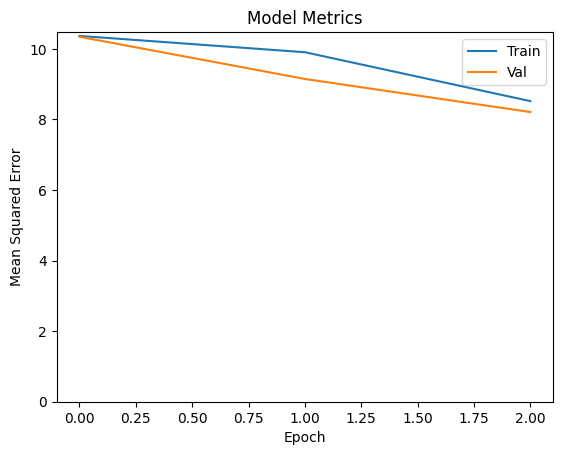

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylim(0, None)
plt.legend(['Train', 'Val'], loc='best');

### Evaluation

In [ ]:
eval = model.evaluate([test_data['userId'], test_data['movieId']], test_data['rating'])

313/313 [==============================] - 1s 2ms/step - loss: -11.2393 - mean_squared_error: 8.2844


### Get Recommendations

In [ ]:
user_id = 1

movies_not_watched = ratings[ratings['userId'] != user_id]['movieId'].unique()
user_ids = np.array([user_id] * len(movies_not_watched))

predictions = model.predict([user_ids, movies_not_watched])

284/284 [==============================] - 1s 2ms/step


In [ ]:
recommendations = pd.DataFrame(list(zip(movies_not_watched, predictions)), columns=['movieId', 'predicted_rating'])
recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)
recommendations.head(10)

,movieId,predicted_rating
29,296,[0.9849941]
123,260,[0.98398256]
37,356,[0.9827906]
72,593,[0.98271483]
177,1270,[0.9825372]
403,1,[0.98132044]
52,480,[0.98128337]
79,318,[0.9811204]
160,1198,[0.98106456]
7,110,[0.98099697]


The predicted ratings are being scaled down to a range of 0 to 1 by the sigmoid function.